# Fuel Efficiency Project
## Marianne Sorba & Maxime Kaniewicz 


In this project, we use historical data collected by the department of energy that can be found at https://www.fueleconomy.gov/feg/download.shtml. The goal is to predict Fuel Efficiency of cars based on their construction characteristics. The predicted variable is called "Comb Unrd Adj FE - Conventional Fuel". For this, we will use 2015-2017 as training data and 2018 as test data.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import  train_test_split, cross_val_score,GridSearchCV,ShuffleSplit
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,Imputer, PolynomialFeatures, MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Unfortunately, the database we are using contains many other variables that measure things related to Fuel efficiency, like CO2 emissions etc. Since we want to focus solely on construction characteristics of the cars, we need to exclude these variables.

For the first step of this project, we create the train and test data frames and delete the unwanted features (other measurements, date, etc.). We shuffle the train data to make an i.i.d assumption through the years. The training and testing set contain 82 features. The training set has 3701 observations, and the testing set 1220.

In [19]:
df_train=pd.concat([pd.read_excel("../2015.xlsx"),pd.read_excel("../2016.xlsx"),pd.read_excel("../2017.xlsx")]).drop(["Model Year","Release Date", "Index (Model Type Index)"],axis=1)
df_test=pd.read_excel("../2018.xlsx").drop(["Model Year","Release Date", "Index (Model Type Index)"],axis=1)
df_train = shuffle(df_train)#shuffle for iid
df_test=shuffle(df_test)#shuffle for iid
y_train=df_train["Comb Unrd Adj FE - Conventional Fuel"]
y_test=df_test["Comb Unrd Adj FE - Conventional Fuel"]

In [20]:
delete = ["FE", "EPA", "Smog", "CO2", "Guzzler", "MPG","fuel","Fuel"]

In [21]:
to_delete = []
for col in df_train.columns.values:
    for name in delete:
        if name in col:
            to_delete.append(col)

In [22]:
df_train = df_train.drop(to_delete, axis = 1)
df_test = df_test.drop(to_delete, axis = 1)

In [23]:
df_train.shape, df_test.shape

((3701, 82), (1220, 82))

In our next step, we drop columns that contain more than 90% of nans on the basis that they will complexify the model without giving much information. After dropping those columns, there are 45 columns left.

In [24]:
columns_perc_nan=df_train.isna().sum()/len(df_train)
drop_columns_nan=list(columns_perc_nan[columns_perc_nan>0.90].index)
df_train=df_train.drop(drop_columns_nan,axis=1)
df_test=df_test.drop(drop_columns_nan,axis=1)

In [25]:
df_train.shape

(3701, 45)

## Linear Models

*Measure performance of a linear model using the provided features with appropriate
preprocessing.*

In this part, we are going to preprocess the numerical features of our training set, and use them to perform a linear regression on this data. We only use numerical data for this part because categorical data requires building derived dummy variables, which we will perform later.

To deal with missing values, we replace them with the median for each column (Most of the numerical features are discete so it makes sense to use the median). We decided not to scale our data because it does not significantly improve our score.  

Using just numerical features for the linear regression, we obtain a validation score of **0.680** . We improve this validation score to **0.705** by studying the linear dependency of the different features and the predicted variable, and by keeping only relevant features and logtransforming them.

In [26]:
df_train["Drive Sys"] = df_train["Drive Sys"].apply(str) # column with integers and strings

In [27]:
columns_numeric=df_train.select_dtypes(include=['int64','float64']).columns#list of numerical variables
columns_categorical=df_train.select_dtypes(include='object').columns#list of categorical variables

In [28]:
mean_pipe = make_pipeline(Imputer(strategy="median"),LinearRegression())
scores = cross_val_score(mean_pipe, df_train[columns_numeric], y_train, cv = 10)
print(np.mean(scores))

0.6801286128831244


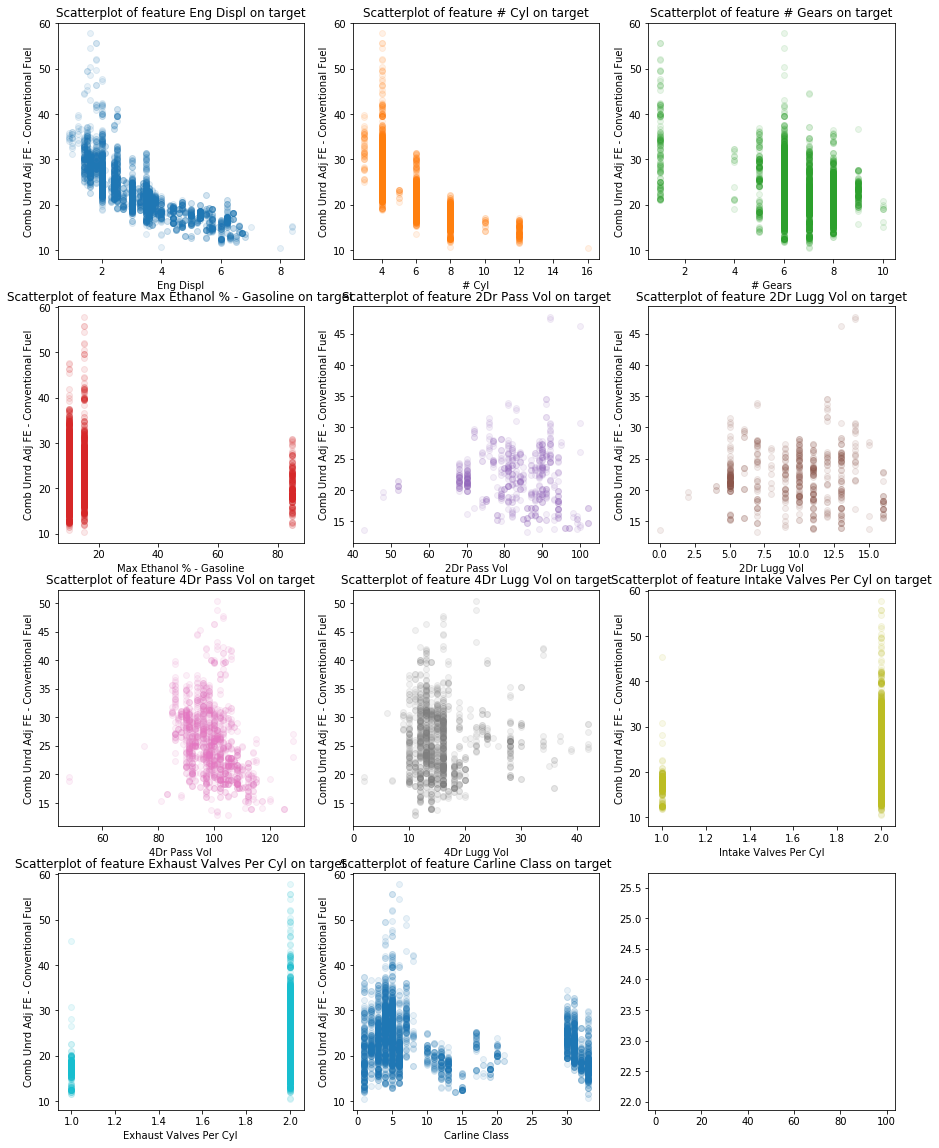

In [29]:
fig,ax=plt.subplots(4,3,figsize=(15,20))
k=0
for i in range(4):
    for j in range(3):
        if k<11:
            sns.regplot(df_train[columns_numeric][df_train[columns_numeric].columns[k]],y_train, ax=ax[i][j],scatter_kws={'alpha':0.1},fit_reg=False)
            ax[i][j].set_title("Scatterplot of feature {} on target".format(df_train[columns_numeric].columns[k]))
            k+=1

In [30]:
#droping numerical features that are not correlated to target
columns_numeric=columns_numeric.drop(['4Dr Lugg Vol','2Dr Lugg Vol','Intake Valves Per Cyl', 'Exhaust Valves Per Cyl'])

In [31]:
#log transformation
df_train[columns_numeric]=np.log(df_train[columns_numeric])
df_test[columns_numeric]=np.log(df_test[columns_numeric])

In [32]:
mean_pipe = make_pipeline(Imputer(strategy="median"),LinearRegression())
scores = cross_val_score(mean_pipe, df_train[columns_numeric], y_train, cv = 10)
print(np.mean(scores))

0.7054719302516367


#### In this part, we test our model on a different train/test split to test the i.i.d assumption.

In [33]:
df_iid=pd.concat([df_train[columns_numeric],df_test[columns_numeric]])
y_iid=y_train.append(y_test)
df_train_iid,df_test_iid, y_train_iid, y_test_iid = train_test_split(df_iid,y_iid, test_size=len(df_test)/(len(df_test)+len(df_train)), random_state=0)

In [34]:
# Here we test our model on the test dataset.
imp=Imputer(strategy="median")
df_train_iid_t=imp.fit_transform(df_train_iid)
df_test_iid_t=imp.transform(df_test_iid)
reg=LinearRegression()
reg.fit(df_train_iid_t,y_train_iid)
print("Final train score  for iid spit = {}".format(reg.score(df_train_iid_t,y_train_iid)))
print("Final test score for iid split = {}".format(reg.score(df_test_iid_t,y_test_iid)))

Final train score  for iid spit = 0.6928973521338563
Final test score for iid split = 0.683554806113253


We can see that the score on the test set is about 3 points larger using a test split on the whole dataset. This means that the iid assumption does not hold on this dataset.

# Task 2 Feature Engineering

*Build non-linear features or derived features from the provided column. Try to improve the
performance of a linear model with these.*

In this part, we created the dummy variables for each categorical data after some preprocessing and feature selection. We then build polynomial features (second degree) to see if the score could be improved. The polynomial features did not improve our score and higly complexified our model, so we did not keep them in our model.

We decided to drop features that had more than 50 categories because they complexify the model (add 50+ variables) without adding much information.

To deal with different categories for the train set and the test set, we droped all dummy features from the test set that are not on the test set, and add null columns to the test set for the dummy features that are in the train set but not on the test set. Doing this, we modify the test set such that there is no information leak on the train set.

Our first score is really low because we have too much variables (300+). We improve the validation score to 0.954 by droping the non-significant features (99%)  based on their p-value, and by keeping the 100 most significant variables (after 100 the score doesn't improve significantly). 

The train score for the final model is  **0.956**, and the test score (on the 2018 dataset) is **0.922.**

The last part of this task is the iid testing : we test the performance of our model on a different random train/test split to test the iid assumption between the data of 2018 and the data of 2017,2016,2015. The conclusion is interesting: the data is clearly not iid, we get a slightly lower train score (**0.9507**) and a significantly higher test score (**0.9506**) for the random split. This could indicate that within each year cluster, the data is correlated. Therefore, without the random split, the linear regression doesn't perform as good on the test set because it doesn't learn anything from the 2018 data, which contains information that is "unique" to this cluster.

In [35]:
cols_cat = [x for x in columns_categorical if 2 <= len(df_train[x].unique()) <= 50]

In [36]:
df_train = df_train[cols_cat+list(columns_numeric)]
df_test=df_test[cols_cat+list(columns_numeric)]

In [37]:
df_train_dummies=pd.get_dummies(df_train)
#this variable is supposed to be object like in the train data 
df_test["GHG Rating (1-10 rating on Label)"]=df_test["GHG Rating (1-10 rating on Label)"].astype("object")
df_test_dummies=pd.get_dummies(df_test)

In [38]:
intersect = np.intersect1d(df_train_dummies.columns.values,df_test_dummies.columns.values)

In [39]:
train_not_test = [col for col in df_train_dummies.columns.values if col not in intersect]
test_not_train = [col for col in df_test_dummies.columns.values if col not in intersect]

In [40]:
for col in train_not_test:
    df_test_dummies[col] = 0
df_test_dummies = df_test_dummies.drop(test_not_train, axis=1)
df_test_dummies = df_test_dummies[df_train_dummies.columns.values]

In [41]:
mean_pipe = make_pipeline(Imputer(strategy="median"),LinearRegression())
scores = cross_val_score(mean_pipe, df_train_dummies, y_train,cv = 10)
np.mean(scores)
#The score is really bad because we have too many useless columns --> feature selection

-2.6412386676047923e+18

In [42]:
#Getting rid of variables not significant to 99% interval
p_value=f_regression(Imputer(strategy="median").fit_transform(df_train_dummies),y_train)[1]
sign_cols = [i[0] for i in df_train_dummies.columns[np.argwhere(p_value<=0.01)]]
p_value=p_value[[i[1] for i in np.argwhere([p_value<=0.01])]]
sorted_sign_cols=[sign_cols[k] for k in np.argsort(p_value)]

In [43]:
#plotting the r² score based on the number of sorted significant variables we keep.
#We keep 32 variables
Score=[]
for n in range(1,len(sorted_sign_cols)):
    mean_pipe = make_pipeline(Imputer(strategy="median"),LinearRegression())
    scores = cross_val_score(mean_pipe, df_train_dummies[sorted_sign_cols[:n]], y_train, cv =ShuffleSplit(n_splits=10, test_size=0.1, random_state=0))
    Score.append(np.mean(scores))

(0.7, 1)

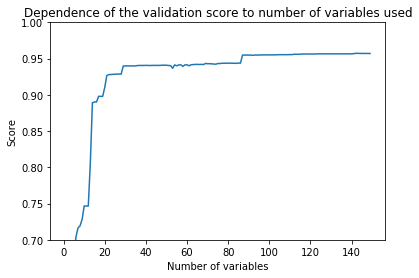

In [44]:
plt.plot(np.arange(1,150),Score[:149])
plt.title("Dependence of the validation score to number of variables used")
plt.xlabel("Number of variables")
plt.ylabel("Score")
plt.ylim(0.7,1)

In [45]:
#Keeping only 100 most significant features
df_train_best_dummies=df_train_dummies[sorted_sign_cols[:100]]
df_test_best_dummies=df_test_dummies[[i for i in sorted_sign_cols[:100] if i in df_test_dummies.columns]]
mean_pipe = make_pipeline(Imputer(strategy="median"),LinearRegression())
scores = cross_val_score(mean_pipe, df_train_best_dummies, y_train, cv =10)
np.mean(scores)

0.9539196197588721

In [46]:
# Here we test our model on the test dataset.
imp=Imputer(strategy="median")
df_train_best_dummies_t=imp.fit_transform(df_train_best_dummies)
df_test_best_dummies_t=imp.transform(df_test_best_dummies)
reg=LinearRegression()
reg.fit(df_train_best_dummies_t,y_train)
print("Final train score = {}".format(reg.score(df_train_best_dummies_t,y_train)))
print("Final test score = {}".format(reg.score(df_test_best_dummies_t,y_test)))

Final train score = 0.9565046450771912
Final test score = 0.9221923223935361


#### In this part, we test our model on a different train/test split to test the i.i.d assumption.

In [47]:
df_iid=pd.concat([df_train_best_dummies,df_test_best_dummies])
y_iid=y_train.append(y_test)
df_train_iid,df_test_iid, y_train_iid, y_test_iid = train_test_split(df_iid,y_iid, test_size=len(df_test)/(len(df_test)+len(df_train)), random_state=0)

In [48]:
# Here we test our model on the test dataset.
imp=Imputer(strategy="median")
df_train_iid_t=imp.fit_transform(df_train_iid)
df_test_iid_t=imp.transform(df_test_iid)
reg=LinearRegression()
reg.fit(df_train_iid_t,y_train_iid)
print("Final train score  for iid spit = {}".format(reg.score(df_train_iid_t,y_train_iid)))
print("Final test score for iid split = {}".format(reg.score(df_test_iid_t,y_test_iid)))

Final train score  for iid spit = 0.950466357996968
Final test score for iid split = 0.950972708220565


We can see that the score on the test set is still about 3 points larger using a test split on the whole dataset. This means that the iid assumption does not hold on this dataset.

## Beyond linear regression

Here, we chose to use the Randon Forest Regressor as a non linear algorithm. We chose to set n_estimators = 100, and to gridsearch on the min_samples_leaf parameter. For the missing values, we are still using the Imputer function in the pipeline. We chose to keep all the dummy variables created in the last steps, without doing any feature selection as we assume that the Random Forest will be able to select the most useful ones by itself.

It turns out that the best parameter for min_samples_leaf is the smallest value we tested, min_samples_leaf = 3. The cross validation score drops as this parameter increases.

With the Random Forest Regressor, we are able to improve our model. The final train score is **0.980** and the test score is **0.953**.

When using the same estimator on a random test set, we achieve better results on the test score, as we get a test score of 0.983, which is 3 points more than with the time split. We can therefore claim that the iid hypothesis does not hold.

In [49]:
RFR = RandomForestRegressor(n_estimators = 100)

In [50]:
mean_pipe = make_pipeline(Imputer(strategy="median"),RFR)

In [51]:
parameters = {'randomforestregressor__min_samples_split' : np.arange(3,30,3)}

In [52]:
grid = GridSearchCV(mean_pipe, parameters, cv=10)
grid.fit(df_train_dummies, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...imators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__min_samples_split': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
grid.best_params_

{'randomforestregressor__min_samples_split': 3}

In [54]:
grid.best_score_

0.9804164471596474

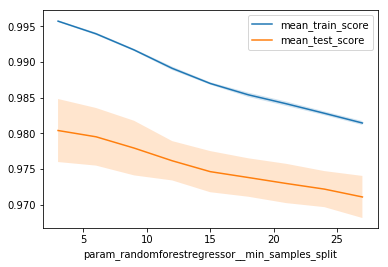

In [55]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_randomforestregressor__min_samples_split', 'mean_train_score')
results.plot('param_randomforestregressor__min_samples_split', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_randomforestregressor__min_samples_split.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_randomforestregressor__min_samples_split.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

In [56]:
grid.score(df_test_dummies, y_test)

0.9530634976197258

#### In this part, we test our model on a different train/test split to test the i.i.d assumption.

In [57]:
df_iid=pd.concat([df_train_dummies,df_test_dummies])
y_iid=y_train.append(y_test)
df_train_iid,df_test_iid, y_train_iid, y_test_iid = train_test_split(df_iid,y_iid, test_size=len(df_test)/(len(df_test)+len(df_train)), random_state=0)

In [70]:
# Here we test our model on the test dataset.
imp=Imputer(strategy="median")
df_train_iid_t=imp.fit_transform(df_train_iid)
df_test_iid_t=imp.transform(df_test_iid)
reg=RandomForestRegressor(n_estimators = 100, min_samples_split = 3)
reg.fit(df_train_iid_t,y_train_iid)
print("Final train score  for iid spit = {}".format(reg.score(df_train_iid_t,y_train_iid)))
print("Final test score for iid split = {}".format(reg.score(df_test_iid_t,y_test_iid)))

Final train score  for iid spit = 0.9954451411223204
Final test score for iid split = 0.9825574810184488


We can see that the score on the test set is still about 3 points larger using a test split on the whole dataset. This means that the iid assumption does not hold on this dataset.

# Feature selection

In this part, we looked at which features are most important for the Random Forest regressor. Two features stand out : the Engine Displacement, whcih measures the capacity of the Engine, and the GHG Rating, which is an indicator of Green House Gas emission.

We then plot the cross validation test score on the number of variables kept, with the variables being ordered by importance. It can be seen that this score roughly remains the same with the 50 most important variables. We then retrained the model using only the 50 most important features, and the test score we got was pretty much the same, **0.952**. It's worth doing this selection as the model will predict much faster and is also much faster to train.

In [59]:
rf = grid.best_estimator_.steps[1][1]

In [60]:
importances = rf.feature_importances_

In [61]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [62]:
names = df_train_dummies.columns.values

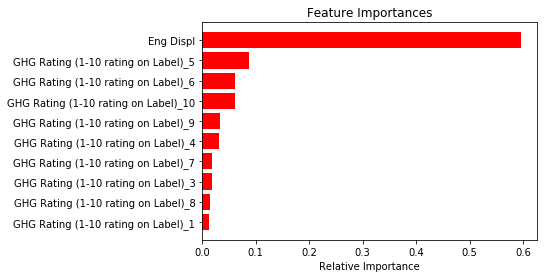

In [63]:
features = df_train_dummies.columns.values
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:10][::-1]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

The most used variables are Engine Displacement and GHG Rating.

Engine Displacement measures the capacity of the engine, as such it is natural that it would be correlated with our target. GHG Rating gives a Rating of the GreenHouse Gases emissions. It is not surprizing that it would be so useful for our model.

In [64]:
Score = []
estimator = grid.best_estimator_
for n in range(1,len(df_train_dummies.columns.values),5):
    best_indices = np.argsort(importances)[::-1][0:n]
    df_train_n_dummies = df_train_dummies[features[best_indices]]
    df_test_n_dummies = df_test_dummies[features[best_indices]]
    scores = cross_val_score(estimator, df_train_n_dummies, y_train, cv =10)
    Score.append(np.mean(scores))

(0.7, 1)

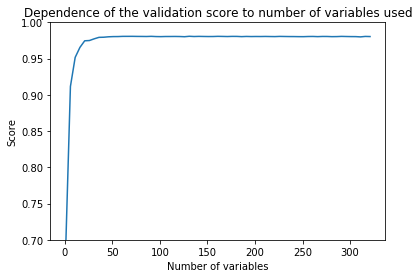

In [65]:
plt.plot(np.arange(1,len(df_train_dummies.columns.values),5),Score)
plt.title("Dependence of the validation score to number of variables used")
plt.xlabel("Number of variables")
plt.ylabel("Score")
plt.ylim(0.7,1)

From this plot, we can see that if we keep the 50 most important features, the validation score of our model won't be affected.

In [66]:
best_indices = np.argsort(importances)[::-1][0:50]

In [67]:
df_train_n_dummies = df_train_dummies[features[best_indices]]
df_test_n_dummies = df_test_dummies[features[best_indices]]

In [68]:
estimator.fit(df_train_n_dummies, y_train)

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...imators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [69]:
estimator.score(df_test_n_dummies, y_test)

0.9520363414386526